# Example: Multiple species Reaction Kinetics using ODEModel
In this example we shall fit to a complex system of ODEs, based on that published by [Polgar et al](https://doi.org/10.1016/j.eurpolymj.2017.03.020). However, we shall be generating some mock data instead of using the real deal. 

In [1]:
from symfit import (
	variables, parameters, ODEModel, D, Fit
) 
from symfit.core.support import key2str
import numpy as np
import matplotlib.pyplot as plt


First we build a model representing the system of equations.


In [2]:
t, F, MM, FMM, FMMF = variables('t, F, MM, FMM, FMMF')
k1_f, k1_r, k2_f, k2_r = parameters('k1_f, k1_r, k2_f, k2_r')

MM_0 = 10  # Some made up initial amount of [FF]

model_dict = {
    D(F, t): - k1_f * MM * F + k1_r * FMM - k2_f * FMM * F + k2_r * FMMF,
	D(FMM, t): k1_f * MM * F - k1_r * FMM - k2_r * FMM * F + k2_f * FMMF,
    D(FMMF, t): k2_f * FMM * F - k2_r * FMMF,
    D(MM, t): - k1_f * MM * F + k1_r * FMM,
}
model = ODEModel(
    model_dict, 
    initial={t: 0.0, MM: MM_0, FMM: 0.0, FMMF: 0.0, F: 2 * MM_0}
)
print(model)

Derivative(F, t; k1_f, k1_r, k2_f, k2_r) = -k1_f*F*MM + k1_r*FMM - k2_f*F*FMM + k2_r*FMMF
Derivative(FMM, t; k1_f, k1_r, k2_f, k2_r) = k1_f*F*MM - k1_r*FMM + k2_f*FMMF - k2_r*F*FMM
Derivative(FMMF, t; k1_f, k1_r, k2_f, k2_r) = k2_f*F*FMM - k2_r*FMMF
Derivative(MM, t; k1_f, k1_r, k2_f, k2_r) = -k1_f*F*MM + k1_r*FMM


Generate mock data.


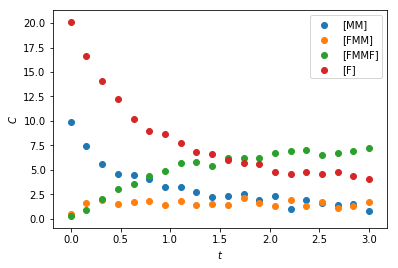

In [3]:
tdata = np.linspace(0, 3, 20)
data = model(t=tdata, k1_f=0.1, k1_r=0.2, k2_f=0.3, k2_r=0.3)._asdict()
sigma_data = 0.3
np.random.seed(42)
for var in data:
	data[var] += np.random.normal(0, sigma_data, size=len(tdata))

plt.scatter(tdata, data[MM], label='[MM]')
plt.scatter(tdata, data[FMM], label='[FMM]')
plt.scatter(tdata, data[FMMF], label='[FMMF]')
plt.scatter(tdata, data[F], label='[F]')
plt.xlabel(r'$t$')
plt.ylabel(r'$C$')
plt.legend()
plt.show()

Perform the fit. Let's pretend that for experimental reasons, we can only measure the concentration for ``MM`` and ``F``, but not for the intermediate `FMM` nor the product `FMMF`. This is no problem, as we can tell ``symfit`` to ignore those components by setting the data for them to `None`.

In [4]:
k1_f.min, k1_f.max = 0, 1
k1_r.min, k1_r.max = 0, 1
k2_f.min, k2_f.max = 0, 1
k2_r.min, k2_r.max = 0, 1

fit = Fit(model, t=tdata, MM=data[MM], F=data[F],
          FMMF=None, FMM=None,
          sigma_F=sigma_data, sigma_MM=sigma_data)
fit_result = fit.execute()
print(fit_result)


Parameter Value        Standard Deviation
k1_f      9.540426e-02 4.440700e-03
k1_r      1.065130e-01 7.165679e-02
k2_f      2.706117e-01 5.305035e-02
k2_r      2.633613e-01 5.647220e-02
Status message         b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Number of iterations   30
Objective              <symfit.core.objectives.LeastSquares object at 0x00000262DBB69A20>
Minimizer              <symfit.core.minimizers.LBFGSB object at 0x00000262F8938CC0>

Goodness of fit qualifiers:
chi_squared            33.98549455298767
objective_value        16.992747276493834
r_squared              0.9936568366360846


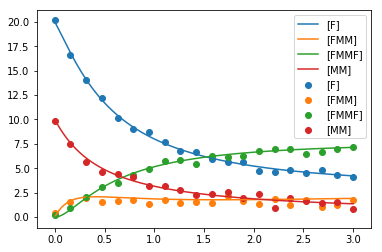

In [5]:
taxis = np.linspace(tdata.min(), tdata.max(), 1000)
model_fit = model(t=taxis, **fit_result.params)._asdict()
for var in data:
	plt.scatter(tdata, data[var], label='[{}]'.format(var.name))
	plt.plot(taxis, model_fit[var], label='[{}]'.format(var.name))
plt.legend()
plt.show()

We see that the lack of data for some components is not a problem, they are predicted quite nicely.

